In [1]:
# -*- coding: utf-8 -*-
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import cv2 as cv
from PIL import Image
import load_data
from load_data import ForamDataSet
from importlib import reload
from timeit import default_timer as timer

plt.ion()   # interactive mode
train_on_gpu = torch.cuda.is_available()


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # val does not use augmentation
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # test does not use augmentation
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = '../media'
image_datasets = {}
image_datasets['train'] = ForamDataSet(csv_file='../train.csv',
                                       root_dir='../media',
                                       transform=data_transforms['train'])
image_datasets['val'] = ForamDataSet(csv_file='../val.csv',
                                     root_dir='../media',
                                     transform=data_transforms['val'])
image_datasets['test'] = ForamDataSet(csv_file='../test.csv',
                                     root_dir='../media',
                                     transform=data_transforms['test'])                                     
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
classes = image_datasets['train'].labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def visualize_frequency(path='../all.csv'):
    df = pd.read_csv(path)
    df = df.groupby('species').count()
    arr = [tuple((x)) for x in df.to_records()]
    arr = sorted(arr, key=lambda x:x[1], reverse=True)
    species = [str(i[0]) for i in arr]
    frequency = [int(i[1]) for i in arr]
    
    y_pos = np.arange(len(species))
    plt.bar(y_pos, frequency, align='center', alpha=0.5)
    plt.xticks(y_pos, species)
    plt.xticks(rotation=80)
    plt.ylabel('Frequency')
    plt.title('Species')

    plt.show()

csv_file = pd.read_csv('../all.csv')


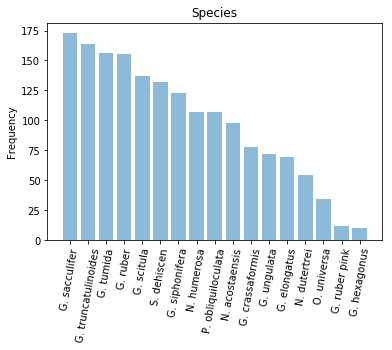

In [5]:
visualize_frequency()

In [6]:
train = image_datasets['train']
val = image_datasets['val']
test = image_datasets['test']
assert(train.labels == val.labels == test.labels)

In [7]:
def visualize_categories():
    train_csv = pd.read_csv('../train.csv').groupby('species').count()
    val_csv = pd.read_csv('../val.csv').groupby('species').count()
    test_csv = pd.read_csv('../test.csv').groupby('species').count()
    merged_csv = pd.merge(pd.merge(train_csv, val_csv, on='species'), test_csv, on='species')
    merged_csv.columns = ['n_train', 'n_val', 'n_test']
    print(merged_csv.sort_values(by=['n_train'], ascending=False))
visualize_categories()


                     n_train  n_val  n_test
species                                    
G. sacculifer             96     39      38
G. ruber                  91     29      35
G. tumida                 89     32      35
G. truncatulinoides       83     38      43
G. scitula                63     44      30
G. siphonifera            58     30      35
S. dehiscen               58     38      36
N. humerosa               55     27      25
N. acostaensis            49     28      21
P. obliquiloculata        43     29      35
G. ungulata               38     15      19
G. elongatus              31     17      21
G. crassaformis           30     22      26
N. dutertrei              24     16      14
O. universa               21      8       5
G. ruber pink              4      5       3


In [9]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving the best model
#
# In the following, parameter ``scheduler`` is an LR scheduler object from
# ``torch.optim.lr_scheduler``.


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # print(outputs)
                    loss = criterion(outputs, labels)
                    # print('loss:', loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), './resnet18-foram.pth')
    return model

In [ ]:
def train_better(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print('Model has been trained for: {n} epochs.\n'.format(n=model.epochs))
    except:
        model.epochs = 0
        print('Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
#             print(
#                 'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
#                 end='\r')

        # After training loops ends, start validation
        else:
            print('Epoch: {epoch}, out of: {max_epoch}'.format(epoch=epoch, max_epoch=n_epochs))
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        '\nEpoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}'.format(epoch=epoch, train_loss=train_loss, valid_loss=valid_loss)
                    )
                    print(
                        '\t\tTraining Accuracy: {train_acc}%\t Validation Accuracy: {valid_acc}%'.format(train_acc=(100*train_acc), valid_acc=(100*valid_acc))
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            '\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min} and acc: {valid_acc}%'.format(epoch=epoch, best_epoch=best_epoch, valid_loss_min=valid_loss_min, valid_acc=valid_acc)
                        )
                        total_time = timer() - overall_start
                        print(
                            '{total_time:.2f} total seconds elapsed. {per_epoch} seconds per epoch.'.format(total_time=total_time, per_epoch=total_time/(epoch+1))
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        '\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'.format(best_epoch=best_epoch, valid_loss_min=valid_loss_min, valid_acc=valid_acc)
    )
    print(
        '{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'.format(total_time=total_time, per_epoch=total_time/epoch)
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history


In [11]:
# Generic function to display predictions for a few images

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
def create_model(model_type):
    criteria = {}
    if model_type == 'the_first':
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(classes)) # resets finaly layer
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
    if model_type == 'vgg':
        model = models.vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, len(classes)), nn.LogSoftmax(dim=1))
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters())
        
    criteria['model'] = model
    criteria['optimizer'] = optimizer
    criteria['criterion'] = criterion
    criteria['train_loader'] = dataloaders['train']
    criteria['valid_loader'] = dataloaders['val']
    criteria['save_file_name'] = './vgg16-transfer-4.pth'
#     criteria['max_epochs_stop'] = 
    criteria['n_epochs'] = 20
#     criteria['print_every'] = 
    model.idx_to_class = {num:species for num,species in enumerate(image_datasets['train'].labels)}
    model, history = train_better(**criteria)
    return model, history
    

In [17]:
model, history = create_model('vgg')

Starting Training from Scratch.

Epoch: 0, out of: 20
tensor([[-3.6559, -4.1093, -4.5927, -2.1332, -5.3630, -2.3389, -1.7674, -3.2110,
         -2.2671, -3.2420, -3.8117, -2.1065, -3.3808, -2.6746, -4.3207, -2.6463,
         -3.1392],
        [-3.4516, -3.7561, -5.1387, -3.0588, -5.0597, -2.7682, -3.6643, -2.3161,
         -3.2588, -1.8556, -3.9784, -2.7421, -2.6997, -1.4712, -3.1514, -3.5219,
         -2.9649],
        [-4.1283, -4.2813, -5.8571, -3.2634, -6.5843, -2.8438, -4.8848, -2.2482,
         -4.7744, -3.0713, -5.8272, -2.6891, -2.4184, -0.7073, -5.2465, -4.0194,
         -3.6792],
        [-3.2838, -4.7556, -6.5183, -3.5228, -7.0350, -3.9478, -2.7760, -3.9035,
         -2.6619, -2.5925, -4.2553, -2.5025, -3.8552, -1.4523, -3.4083, -2.0808,
         -1.7931]])
tensor([[-5.3019, -3.9595, -7.2004, -0.4070, -7.2958, -3.0110, -4.9897, -4.0345,
         -4.8796, -4.0003, -5.5849, -3.6834, -5.3897, -2.0114, -6.4531, -3.6619,
         -4.2186],
        [-6.0221, -7.1199, -9.9451, -5.5

tensor([[-7.8854, -4.1268, -7.9385, -0.2329, -8.3492, -2.4549, -7.9402, -3.7656,
         -7.2739, -6.0571, -7.7460, -5.3686, -6.7628, -2.6647, -8.6158, -7.6800,
         -6.3657],
        [-4.6527, -2.9423, -4.5046, -1.2323, -4.6125, -2.2844, -3.5922, -1.8795,
         -4.2564, -3.9702, -3.6053, -2.8504, -3.0150, -1.9321, -4.6018, -4.7570,
         -4.3810],
        [-3.8203, -2.5191, -4.7159, -1.9537, -4.6107, -2.3192, -3.4744, -2.0090,
         -3.5753, -2.7016, -3.4545, -2.7404, -2.9181, -2.0678, -3.7022, -3.4536,
         -3.0922],
        [-3.9101, -2.4989, -5.7175, -1.8117, -5.0689, -2.2837, -3.6867, -3.2078,
         -3.0829, -1.9592, -3.2831, -3.8094, -4.5178, -2.4138, -3.0302, -3.1307,
         -2.1323]])
tensor([[-3.5500, -4.2700, -5.9187, -3.6177, -6.6716, -3.5023, -2.8414, -2.6685,
         -3.1928, -3.4480, -4.7091, -2.3962, -2.2694, -1.0384, -4.0899, -2.7720,
         -2.8294],
        [-3.2579, -4.2170, -5.2014, -2.5953, -5.8249, -2.8655, -1.9711, -3.3023,
         -2.0

tensor([[-3.7939, -4.2244, -6.1711, -3.1524, -5.8904, -3.8533, -2.4773, -3.9185,
         -2.3376, -1.4926, -1.9416, -3.2481, -4.1909, -3.0086, -2.8360, -2.7220,
         -2.3265],
        [-3.8604, -4.0874, -6.3168, -2.1612, -6.6566, -3.4315, -4.2957, -3.5676,
         -3.9098, -2.8283, -4.9873, -2.7215, -4.4043, -0.8832, -4.3777, -2.2991,
         -2.5341],
        [-3.2547, -4.1490, -5.8936, -3.9548, -5.8885, -3.1089, -3.5763, -3.8641,
         -3.6711, -1.0012, -4.0840, -3.0630, -3.4604, -2.2004, -3.4951, -2.3363,
         -2.2863],
        [-4.9587, -4.3051, -7.5405, -4.1418, -6.6797, -3.2413, -1.7999, -5.8151,
         -4.1756, -1.7121, -0.6975, -4.6140, -4.6290, -5.0448, -4.4639, -4.2840,
         -4.6813]])
tensor([[-3.1742, -5.5890, -7.5593, -4.2925, -7.6605, -4.8403, -3.5841, -4.8873,
         -2.2578, -1.1136, -4.7659, -3.4338, -4.6028, -2.3372, -3.4693, -1.8567,
         -2.0489],
        [-3.2281, -3.4319, -5.3315, -2.3444, -5.6788, -3.4115, -2.9039, -3.4323,
         -3.0

tensor([[-3.3053, -4.1632, -5.3417, -2.5571, -5.6243, -2.7173, -2.9345, -3.2136,
         -2.8295, -2.6532, -4.2205, -2.3524, -3.4559, -1.5099, -3.8876, -2.3650,
         -2.3417],
        [-3.6829, -5.3641, -7.3825, -4.3928, -7.4747, -4.1643, -2.6527, -4.6174,
         -1.7887, -2.0973, -4.3858, -3.6540, -4.5498, -2.7753, -2.6124, -1.9982,
         -1.3839],
        [-3.5867, -5.5837, -7.4376, -4.4474, -7.4946, -4.3414, -4.4005, -4.4944,
         -3.7471, -0.4935, -4.8022, -3.6652, -4.2070, -2.2156, -4.1839, -3.1659,
         -2.6597],
        [-4.4217, -3.9423, -6.0335, -2.1763, -6.4962, -2.1054, -5.2491, -2.5075,
         -4.8275, -2.8378, -6.0272, -2.9801, -3.2984, -0.8322, -5.1862, -3.8805,
         -3.7028]])
tensor([[-5.9317, -6.5224, -8.4493, -4.5082, -9.4376, -5.8700, -0.1842, -6.1958,
         -3.1131, -5.9914, -3.3845, -3.7008, -6.2101, -5.7044, -5.2408, -4.2874,
         -4.0165],
        [-5.2160, -3.2611, -5.2144, -1.5349, -5.9176, -1.6999, -6.4283, -1.6389,
         -5.4

tensor([[-3.1124, -4.4964, -5.8167, -3.3817, -6.4930, -3.6094, -2.6439, -3.4130,
         -2.9518, -2.6938, -4.2065, -2.0097, -2.9513, -1.3716, -3.9607, -2.3431,
         -2.4658],
        [-3.2158, -3.7536, -5.4004, -3.2648, -5.7970, -3.3909, -3.7681, -2.6008,
         -3.6852, -1.9188, -4.2025, -2.4061, -2.6329, -1.3076, -3.8899, -2.9794,
         -2.6725],
        [-3.7342, -4.6343, -6.6476, -3.1833, -7.2096, -4.0301, -0.9627, -4.6626,
         -2.4476, -3.0780, -2.3794, -2.5387, -3.9676, -2.7558, -3.7807, -2.6848,
         -3.3192],
        [-3.5932, -5.7429, -8.3018, -4.3673, -8.5316, -5.6266, -2.0785, -5.1149,
         -1.2922, -2.7224, -3.8893, -3.7610, -4.7876, -2.7165, -3.7313, -1.5570,
         -2.0545]])
tensor([[-4.2208, -2.9069, -5.3542, -2.2121, -5.2882, -1.5078, -3.2968, -2.2964,
         -3.7945, -3.1080, -4.1005, -3.1797, -2.8488, -1.6427, -4.2308, -4.0040,
         -3.1486],
        [-3.8007, -5.3173, -6.7033, -2.9032, -7.3414, -3.8951, -4.6049, -3.5590,
         -3.5

tensor([[-3.3117, -3.7505, -4.2935, -2.5875, -4.7617, -2.9838, -1.7669, -3.2233,
         -2.1692, -2.7145, -3.2322, -2.3944, -3.4336, -2.7520, -3.6321, -2.5846,
         -2.6287],
        [-5.8926, -6.2522, -9.2730, -6.3693, -8.0377, -5.6291, -1.9803, -7.0254,
         -4.3763, -2.7657, -0.2881, -5.4256, -5.5620, -6.8405, -4.9682, -5.3358,
         -5.4276],
        [-4.4235, -5.4263, -7.7317, -4.6067, -7.5601, -5.0406, -1.3195, -5.4368,
         -1.5372, -2.4580, -1.5531, -4.2711, -4.5817, -4.5675, -2.9132, -2.9359,
         -3.2083],
        [-3.4356, -5.0435, -7.1486, -4.1315, -7.3176, -4.6946, -2.6661, -4.4058,
         -1.7410, -1.7569, -3.7948, -3.3497, -3.9558, -2.4785, -2.4236, -2.1736,
         -1.9514]])
tensor([[-5.4968, -2.6544, -5.4289, -1.0204, -5.2542, -1.9671, -4.6634, -1.6615,
         -4.7896, -3.9626, -3.8715, -3.6963, -3.3725, -2.4066, -5.4396, -5.5492,
         -4.5341],
        [-3.2051, -5.4482, -7.4715, -4.0450, -7.9680, -4.9081, -3.1277, -4.7731,
         -1.9

tensor([[-3.1998, -4.2733, -6.4113, -2.8109, -6.6189, -3.9412, -3.1238, -3.6747,
         -2.9111, -2.5629, -4.1418, -2.5286, -3.9820, -1.3603, -3.7661, -1.9049,
         -2.1285],
        [-3.5313, -5.4912, -7.2679, -4.0760, -8.3329, -4.8512, -1.1025, -5.2629,
         -2.2207, -3.0438, -3.4908, -2.5803, -4.0198, -2.4966, -4.1986, -1.8955,
         -2.5816],
        [-3.9527, -5.3900, -7.5082, -3.9407, -7.9984, -5.4009, -0.9169, -5.4490,
         -1.9390, -3.2372, -1.9665, -3.2409, -4.6656, -3.6885, -3.9969, -2.4003,
         -3.1787],
        [-3.7981, -4.3264, -5.9230, -2.7215, -6.2387, -2.7973, -4.5819, -3.0651,
         -3.9935, -2.0184, -5.1030, -2.5505, -3.6343, -0.9866, -3.9564, -3.1134,
         -2.5529]])
tensor([[-3.0338, -4.1702, -5.7740, -3.1972, -5.9064, -4.0561, -2.5237, -3.7764,
         -2.5742, -1.7229, -2.8739, -2.7641, -3.3963, -1.9994, -3.1289, -2.1291,
         -2.7578],
        [-3.1092, -5.3794, -7.5573, -3.8528, -8.0495, -4.9919, -2.8157, -4.6133,
         -1.9

tensor([[-4.0968, -4.3470, -5.1780, -2.5773, -5.9069, -3.0889, -0.9996, -3.8876,
         -2.5275, -3.5415, -3.3694, -2.0502, -4.2254, -3.3002, -4.0086, -3.1859,
         -2.6726],
        [-3.5212, -4.1279, -6.3201, -4.0579, -6.1681, -3.2272, -2.2026, -3.9442,
         -2.7705, -1.4082, -2.8750, -2.7360, -3.6103, -2.7204, -3.1935, -2.9134,
         -1.9180],
        [-4.5189, -3.4249, -6.2003, -2.7312, -5.5259, -0.9958, -3.6300, -3.2163,
         -3.4798, -1.8872, -3.7683, -3.7744, -4.2770, -3.1170, -3.6475, -4.3067,
         -2.0933],
        [-4.3261, -5.2321, -7.8774, -4.3449, -7.3170, -4.6604, -4.8721, -5.3102,
         -4.5598, -0.1979, -3.8485, -4.7645, -4.9229, -3.5144, -5.0634, -3.9017,
         -3.8624]])
tensor([[-4.3456, -2.6034, -4.7072, -1.6762, -4.6362, -2.1627, -3.8988, -1.6698,
         -3.8964, -3.4287, -3.8961, -2.9469, -2.9354, -1.9402, -4.1437, -4.2092,
         -3.4878],
        [-4.9182, -2.6288, -5.6452, -1.4097, -5.8376, -1.2748, -4.2428, -2.8145,
         -4.4

tensor([[ -3.4601,  -5.1627,  -6.9956,  -4.6518,  -6.7811,  -4.8050,  -2.7381,
          -4.7330,  -2.5246,  -0.7108,  -3.0237,  -3.8036,  -4.1561,  -3.4872,
          -3.2924,  -2.7659,  -2.5134],
        [ -3.2844,  -4.6124,  -6.1465,  -3.4888,  -6.0417,  -4.3819,  -2.7280,
          -3.8236,  -2.0047,  -1.5481,  -3.1920,  -3.2624,  -3.9307,  -2.4372,
          -2.5101,  -2.5093,  -2.1080],
        [ -7.8791,  -7.2253, -10.8296,  -5.9777, -10.0782,  -5.7446,  -0.8622,
          -9.0595,  -5.4358,  -5.2465,  -0.5939,  -6.0243,  -7.7039,  -7.9410,
          -6.3709,  -6.2110,  -6.1960],
        [ -4.8048,  -3.8261,  -5.0712,  -2.1487,  -5.4819,  -1.2597,  -5.8131,
          -2.1514,  -4.5163,  -3.3190,  -6.3075,  -3.4433,  -3.3964,  -1.2695,
          -4.2524,  -4.5719,  -3.9136]])
tensor([[-4.6584, -2.9717, -4.9455, -1.0472, -4.6163, -1.8981, -4.0428, -2.2127,
         -3.7878, -3.8971, -4.1071, -3.2397, -3.5575, -2.2393, -3.8576, -4.0354,
         -3.8099],
        [-3.2605, -5.2657,

KeyboardInterrupt: 

In [ ]:
model = models.resnet18(pretrained=True)
summary(model,input_size=(3, 224, 224))

In [ ]:
model = models.vgg16(pretrained=True)
summary(model,input_size=(3, 224, 224))

In [ ]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint
    This is better than the default save as you save more info

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    print(path.split('-'))
    model_name = os.path.basename(path).split('-')[0]
    assert (model_name in ['vgg16', 'resnet50', 'resnet18'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet18':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [4]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """
    model = models.resnet18(pretrained=True)
    # Changing the output of the final layer
    model.fc = nn.Linear(model.fc.in_features, 17)
    model.load_state_dict(torch.load(path))
    model.idx_to_class = {num:species for num,species in enumerate(image_datasets['train'].labels)}    
#     for param in model.parameters():
#             param.requires_grad = False
#     if model_name == 'vgg16':
#         model = models.vgg16(pretrained=True)
#         # Make sure to set parameters as not trainable
#         for param in model.parameters():
#             param.requires_grad = False
#         model.classifier = checkpoint['classifier']

#     elif model_name == 'resnet18':
#         model = models.resnet50(pretrained=True)
#         # Make sure to set parameters as not trainable
#         for param in model.parameters():
#             param.requires_grad = False
# #         model.fc = checkpoint['fc']

#     # Load in the state dict
#     model.load_state_dict(checkpoint['state_dict'])

#     total_params = sum(p.numel() for p in model.parameters())
#     print(f'{total_params:,} total parameters.')
#     total_trainable_params = sum(
#         p.numel() for p in model.parameters() if p.requires_grad)
#     print(f'{total_trainable_params:,} total gradient parameters.')

#     # Move to gpu
#     if multi_gpu:
#         model = nn.DataParallel(model)

#     if train_on_gpu:
#         model = model.to('cuda')

#     # Model basics
#     model.class_to_idx = checkpoint['class_to_idx']
#     model.idx_to_class = checkpoint['idx_to_class']
#     model.epochs = checkpoint['epochs']

#     # Optimizer
#     optimizer = checkpoint['optimizer']
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model

In [ ]:
save_checkpoint(model_ft, './resnet18-foram.pth')

In [ ]:
torch.save(model_ft.state_dict(), './resnet18-foram.pth')

In [ ]:
model_ft.load_state_dict(torch.load('./resnet18-foram.pth'))

In [ ]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [ ]:
def imshow_tensor(image, ax=None, title=None):
    """
    Imshow for Tensor.
    Basicaly reverses the image to tensor process
    """

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [ ]:
def predict(model, image_path, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [5]:
model = load_checkpoint('./resnet18-foram.pth')

In [ ]:
predict(model, '../media/G. ruber/0c2434995cae47c392a409114d017e7f.tif')

In [6]:
def accuracy(output, target, topk=(1, )):
    """
    Compute the topk accuracy(s)
    target: the correct answer
    """
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res
    

In [22]:
'''
So how does this weird function actually work?
pred gives you this
tensor([[ 3,  5,  8,  7,  1],
        [12,  0, 13,  7,  5],
        [16, 10,  6,  9,  3],
        [ 9, 15, 14,  8,  0]])
So naturally pred.t gives you
tensor([[ 3, 12, 16,  9],
        [ 5,  0, 10, 15],
        [ 8, 13,  6, 14],
        [ 7,  7,  9,  8],
        [ 1,  5,  3,  0]])
this tensor is compared with
tensor([[ 3, 12,  8,  9],
        [ 3, 12,  8,  9],
        [ 3, 12,  8,  9],
        [ 3, 12,  8,  9],
        [ 3, 12,  8,  9]])
which results in
tensor([[1, 1, 0, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]
And then you simply sum up the entire tensor. The sum will not exceed 4
'''

In [14]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

In [15]:
if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    print(accuracy(model(features), targets, topk=(1, 5)))
print(targets)

[100.0, 100.0]
tensor([15, 16, 15,  7])


In [10]:
print(accuracy(model(features), targets))

[75.0]


In [61]:
def evaluate_for_categories(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, 17), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    for i in topk:
        results = pd.DataFrame(acc_results, columns=['top{i}'.format(i=i) for i in topk])
        results['class'] = classes
        results['loss'] = losses
        results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [62]:
criterion = nn.CrossEntropyLoss()
results = evaluate_for_categories(model, dataloaders['test'], criterion)

In [92]:
print(results)

                  class        top1        top5      loss
0       G. crassaformis   34.615385   80.769231  2.598328
1          G. elongatus   85.714286  100.000000  0.431503
2              G. ruber   82.857143   97.142857  0.699195
3         G. ruber pink   66.666667  100.000000  1.350283
4         G. sacculifer   97.368421  100.000000  0.102437
5            G. scitula   76.666667   83.333333  1.437092
6        G. siphonifera   65.714286  100.000000  0.943208
7   G. truncatulinoides   90.697674   95.348837  0.319898
8             G. tumida  100.000000  100.000000  0.074750
9           G. ungulata   78.947368  100.000000  0.656239
10       N. acostaensis   80.952381  100.000000  0.456945
11         N. dutertrei   78.571429   92.857143  1.069931
12          N. humerosa   84.000000   92.000000  0.792770
13          O. universa    0.000000  100.000000  2.952649
14   P. obliquiloculata   82.857143   91.428571  0.574844
15          S. dehiscen   86.111111  100.000000  0.387484


In [58]:
def overall_accuracy(model, test_loader):
    model.eval()
    with torch.no_grad():
        counter = 0
        result = 0
        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            result += accuracy(model(data), targets)[0]
            counter += 1
    return result/counter

In [64]:
# Evaluate the model on all the training data
results = overall_accuracy(model, dataloaders['test'])

In [ ]:
print(results)

In [67]:
def F1(model, test_loader):
    '''
    class_info = {class_index: [true_postiive,
                                false_positive,
                                total_per_species,
                                precision,
                                recall,
                                F-score]}
    '''
    model.eval()
    class_info = {}
    for i in range(len(image_datasets['train'].labels)):
        class_info[i] = [0,0,0]
    with torch.no_grad():
        for data, targets in test_loader:
            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')
                # Raw model output
            out = model(data)
            _, pred = out.topk(k=1, dim=1, largest=True, sorted=True)
#             print(pred)
#             print(pred.shape)
            pred = torch.squeeze(pred, 1)
            for i in range(len(targets)):
#                 print(pred,targets)
                if pred[i] == targets[i]: # prediction correct, add to true positive
                    temp = class_info[int(pred[i])]
                    temp[0] = temp[0] + 1
                    class_info[int(pred[i])] = temp
                else: # prediction wrong, add to false positive
                    temp = class_info[int(pred[i])]
                    temp[1] = temp[1] + 1
                    class_info[int(pred[i])] = temp
#             break
    test_csv = pd.read_csv('../test.csv').groupby('species').count()
    species = image_datasets['train'].labels
    for i in range(test_csv.shape[0]):
        row = test_csv.iloc[i]
        print(row)
        arr = class_info[species.index(row.name)]
        arr[2] = int(row.location)
        arr.append(arr[0]/(arr[0]+arr[1]))
        arr.append(arr[0]/arr[2])
        arr.append((2*arr[3]*arr[4])/(arr[3]+arr[4]))
        class_info[species.index(row.name)] = arr
    total_true_positives = 0
    total_false_postives = 0
    total = 0
    for key,values in class_info.items():
        total_true_positives += values[0]
        total_false_postives += values[1]
        total += values[2]
    micro_avg_prec = total_true_positives/(total_true_positives+total_false_postives)
    micro_avg_rec = total_true_positives/total
    micro_f1 = (2*micro_avg_prec*micro_avg_rec)/(micro_avg_prec+micro_avg_rec)
    df = pd.DataFrame.from_dict(class_info, orient='index',
                        columns=['true_positive','false_positive','total_per_species','precision','recall','F-score'])
    return micro_f1, df

In [68]:
ans = F1(model, dataloaders['test'])

location    26
Name: G. crassaformis, dtype: int64
location    21
Name: G. elongatus, dtype: int64
location    35
Name: G. ruber, dtype: int64
location    3
Name: G. ruber pink, dtype: int64
location    38
Name: G. sacculifer, dtype: int64
location    30
Name: G. scitula, dtype: int64
location    35
Name: G. siphonifera, dtype: int64
location    43
Name: G. truncatulinoides, dtype: int64
location    35
Name: G. tumida, dtype: int64
location    19
Name: G. ungulata, dtype: int64
location    21
Name: N. acostaensis, dtype: int64
location    14
Name: N. dutertrei, dtype: int64
location    25
Name: N. humerosa, dtype: int64
location    5
Name: O. universa, dtype: int64
location    35
Name: P. obliquiloculata, dtype: int64
location    36
Name: S. dehiscen, dtype: int64


In [56]:
print(ans[1])
print(ans[0])

    true_positive  false_positive  total_per_species  precision    recall  \
0              14               0                 26   1.000000  0.538462   
1              18               5                 21   0.782609  0.857143   
2               0               0                  0        NaN       NaN   
3              31               9                 35   0.775000  0.885714   
4               2               0                  3   1.000000  0.666667   
5              35               5                 38   0.875000  0.921053   
6              22               3                 30   0.880000  0.733333   
7              29               4                 35   0.878788  0.828571   
8              40               4                 43   0.909091  0.930233   
9              35               9                 35   0.795455  1.000000   
10             16               0                 19   1.000000  0.842105   
11             17               7                 21   0.708333  0.809524   